In [6]:
import pymesh

In [7]:
import numpy as np
import sys
sys.path.append("../../../source/")

In [8]:
ground_truth_dir = 'ground_truth/'
masif_pred_dir = 'masif_pred/'
transient_interactions_file = 'testing_transient.txt'

# List of sppider_predictions
sppider_pred_dir = 'sppider_pred/'


In [9]:
# Plot the comparison for transient interactions

transient_pdbs = set([''.join(x[0:4]) for x in open(transient_interactions_file).readlines()])



In [10]:

# To follow SPPIDER's implementation  we only label as interface those residues 
# with points with more than 4% RSA change and at least 5A RSA change.
def is_res_iface(res_labels, vertex_areas):
    sum_iface_area = 0.0
    sum_total_res_area = 0.0

    for ix, label in enumerate(res_labels): 
        sum_total_res_area += vertex_areas[ix]
        if label > 0:
            sum_iface_area += vertex_areas[ix]

    if sum_iface_area > 5.0 and sum_iface_area/sum_total_res_area > 0.04:
        return True
    else:
        return False

In [13]:
# Get the ground truth per residue (as we have it per surface point.)
# Atoms: list of PDB atoms in Biopython format. 
# Residues: list of PDB residues in Biopython format. 
# ground_truth_mesh: a pymesh mesh object with labeled interface (the ground truth.)
# Returns a dict where the key is the residue id and the value is the score. 
def assign_labels_per_residue(atoms, residues, ground_truth_mesh):
    # For every residue, assign a label on whether it is interface or not, based on the buried surface.
    flann = pyflann.FLANN()
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    verts = ground_truth_mesh.vertices.astype(float)

    labels = ground_truth_mesh.get_attribute('vertex_iface')
    ground_truth_mesh.add_attribute("vertex_area")
    vertex_areas = ground_truth_mesh.get_attribute("vertex_area")

    # Compute the closest atom to each vertex. 
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each residue, assign the ground truth based on the closest atom. 
    res_labels = {}
    res_areas = {}
    for ix, v in enumerate(verts): 
        pred = labels[ix]
        res_id = atoms[r[ix]].get_parent().get_id()
        if res_id not in res_labels:
            res_labels[res_id] = []
            res_areas[res_id] = []
        res_labels[res_id].append(pred)
        res_areas[res_id].append(vertex_areas[ix])
    res_labels_tmp = []
    for key in res_labels:
        # To follow SPPIDER's implementation (as an approximation) we only label as interface those residues 
        # with points with more than 4% RSA change and at least 5A RSA change.
        if is_res_iface(res_labels[key], res_areas[key]):
            res_labels[key] = 1.0
        else:
            res_labels[key] = 0.0
    return res_labels

Per residue ROC AUC: 0.59
1XQS_A Per point ROC AUC: 0.52
Per residue ROC AUC: 0.74
4XL5_C Per point ROC AUC: 0.75
Per residue ROC AUC: 0.72
4HDO_A Per point ROC AUC: 0.70
Per residue ROC AUC: 0.69
3BH6_B Per point ROC AUC: 0.64
Per residue ROC AUC: 0.68
4Y61_B Per point ROC AUC: 0.52
Per residue ROC AUC: 0.38
5TIH_A Per point ROC AUC: 0.29
Per residue ROC AUC: 0.59
3RT0_A Per point ROC AUC: 0.58
Per residue ROC AUC: 0.70
3MCA_B Per point ROC AUC: 0.73
Per residue ROC AUC: 0.62
4X33_B Per point ROC AUC: 0.57
Per residue ROC AUC: 0.87
3O5T_A Per point ROC AUC: 0.87
Per residue ROC AUC: 0.82
4ZGY_A Per point ROC AUC: 0.82
Per residue ROC AUC: 0.65
4ZRJ_A Per point ROC AUC: 0.64
Per residue ROC AUC: 0.42
1XG2_A Per point ROC AUC: 0.31
Per residue ROC AUC: 0.68
2MTA_HL Per point ROC AUC: 0.48
Per residue ROC AUC: 0.55
4DVG_B Per point ROC AUC: 0.56
Per residue ROC AUC: 0.77
3VYR_B Per point ROC AUC: 0.74
Per residue ROC AUC: 0.45
2WUS_A Per point ROC AUC: 0.40
Per residue ROC AUC: 0.57
3QML

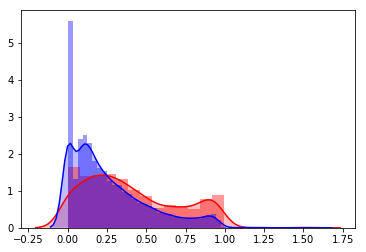

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# Compute the score of each predicted surface. 
from IPython.core.debugger import set_trace
from Bio.PDB import *
import pyflann
import sklearn.metrics
import os

# Compute the ROC AUC for SPPIDER for points and residues. 
# SPPIDER works on residues while we work on points. 
# This method computes ROC AUCs according to both. 
def compute_roc_auc_sppider(pdbid):
    parser = PDBParser()
    struct = parser.get_structure(sppider_pred_dir+pdbid+'.pdb',sppider_pred_dir+pdbid+'.pdb')
    atoms = Selection.unfold_entities(struct, 'A')
    residues = Selection.unfold_entities(struct, 'R')
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    
    ground_truth_mesh = pymesh.load_mesh(ground_truth_dir+pdbid+'.ply')


    flann = pyflann.FLANN()
    
    verts = ground_truth_mesh.vertices.astype(float)
    
    # Compute the closest atom to each vertex in vertices
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each vertex, assign the predictions according 
    pred = np.zeros((n))
    labels = ground_truth_mesh.get_attribute('vertex_iface')
    
    labels_per_residue = assign_labels_per_residue(atoms, residues, ground_truth_mesh)
    
    res_pred = {}
    for res in residues:
        if 'CA' in res:
            res_pred[res.get_id()] = res['CA'].bfactor/100

    res_pred_y = []
    res_label_y = []
    for key in labels_per_residue:
        if key in res_pred and key in labels_per_residue:
            res_pred_y.append(res_pred[key])
            res_label_y.append(labels_per_residue[key])

    try:
        res_roc_auc = sklearn.metrics.roc_auc_score(res_label_y, res_pred_y)
    except:
        res_roc_auc = 0.5
    print('Per residue ROC AUC: {:.2f}'.format(res_roc_auc))
    
    for vi in range(n):
        pred[vi] = atoms[r[vi]].bfactor/100
        
    roc_auc = sklearn.metrics.roc_auc_score(labels, pred)
    print('{} Per point ROC AUC: {:.2f}'.format(pdbid, roc_auc))
    return labels, pred, res_label_y, res_pred_y, roc_auc, res_roc_auc
    
all_pred = []
all_labels = []

all_pred_res = []
all_labels_res = []

all_roc_auc_per_prot_sppider = []
all_res_roc_auc_per_prot_sppider = []

for fn in os.listdir(sppider_pred_dir):  
    pdbid = fn.split('.')[0]

    l, p, res_l, res_p, roc_auc, res_roc_auc = compute_roc_auc_sppider(pdbid)

    all_pred.append(p)
    all_labels.append(l)
    
    all_pred_res.append(res_p)
    all_labels_res.append(res_l)
    
    all_roc_auc_per_prot_sppider.append(roc_auc)
    all_res_roc_auc_per_prot_sppider.append(res_roc_auc)
    
print("Number of proteins: {}".format(len(all_pred)))

all_pred = np.concatenate(all_pred, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

all_pred_by_point_sppider = all_pred.copy()
all_labels_by_point_sppider = all_labels.copy()

#print(metrics.roc_auc_score(all_my_labels_per_res, all_my_pred_per_res))

all_labels_res = np.concatenate(all_labels_res, axis=0)

all_pred_res = np.concatenate(all_pred_res, axis=0)


all_roc_auc = sklearn.metrics.roc_auc_score(all_labels, all_pred)
all_roc_auc_res = sklearn.metrics.roc_auc_score(all_labels_res, all_pred_res)



print('Global ROC AUC: {:.2f}'.format(all_roc_auc))
print('Global ROC AUC per residue: {:.2f}'.format(all_roc_auc_res))

print('Median ROC AUC per protein : {:.2f}'.format(np.median(all_roc_auc_per_prot_sppider)))
print('Median ROC AUC per residue per protein: {:.2f}'.format(np.median(all_res_roc_auc_per_prot_sppider)))

pos_label = np.where(all_labels_res == 1)[0]
pos = all_pred_res[pos_label]
neg_label = np.where(all_labels_res == 0)[0]
neg = all_pred_res[neg_label]
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True}, norm_hist=True)
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True}, norm_hist=True)


In [58]:
# Compute the MASIF predictions per residue.
# Params: myid: PDBID_CHAIN format
# scores: the predicted scores for this one. 
def compute_pred_labels_per_residue(myid, scores):
    # We use the same pdb that sppider predicted. 
    parser = PDBParser()
    # Use the same pdb that sppider used. 
    struct = parser.get_structure(sppider_pred_dir+myid+'.pdb',sppider_pred_dir+myid+'.pdb')
    atoms = Selection.unfold_entities(struct, 'A')
    residues = Selection.unfold_entities(struct, 'R')
    
    ground_truth_mesh = pymesh.load_mesh(ground_truth_dir+myid+'.ply')
    
    res_labels = assign_labels_per_residue(atoms, residues, ground_truth_mesh)
    
    # Now assign predictions to each vert    
    verts = ground_truth_mesh.vertices
    ground_truth_mesh.add_attribute("vertex_area")
    vertex_areas = ground_truth_mesh.get_attribute("vertex_area")
    
    at_coord = np.array([at.get_coord() for at in atoms]).astype(float)
    verts = ground_truth_mesh.vertices.astype(float)
    
    
    residues = [x for x in verts]
    flann = pyflann.FLANN()
    r,d = flann.nn(at_coord, verts)
    d = np.sqrt(d)
    n= len(r)
    
    # For each residue, assign the mean score. 
    res_scores = {}
    res_areas = {}
    for ix, v in enumerate(verts): 
        pred = scores[ix]
        res_id = atoms[r[ix]].get_parent().get_id()
        if res_id not in res_scores:
            res_scores[res_id] = []
            res_areas[res_id] = []
        res_scores[res_id].append(pred)
        res_areas[res_id].append(pred)
    print('Total number of residues {}'.format(len(res_scores.keys())))

    for key in res_scores:
        res_scores[key] =  np.max(res_scores[key])  

    pred_per_res = []
    labels_per_res = []
    for key in res_labels: 
        if key in res_scores and key in res_labels:
            pred_per_res.append(res_scores[key])
            labels_per_res.append(res_labels[key])

    
    return pred_per_res, labels_per_res 

In [59]:
# Compute per residue and per point ROC AUC scores for MASIF> 
def compute_masif_scores():
    all_my_scores = []
    all_my_labels = []
    all_my_auc_per_protein = {}
    all_my_auc_per_res = []
    all_my_names = []
    
    all_my_pred_per_res = []
    all_my_labels_per_res = []
    count = 0

    for name in os.listdir(masif_pred_dir): 

        myid = name.split('.')[0]
        # Load interface for file. 
        mesh = pymesh.load_mesh(masif_pred_dir+'/'+name)
        masif_pred = mesh.get_attribute('vertex_iface')
        all_my_scores.append(masif_pred)
        
        # Load groundtruth for file. 
        mesh = pymesh.load_mesh(ground_truth_dir+'/'+name)
        groundtruth = mesh.get_attribute('vertex_iface')
        all_my_labels.append(groundtruth)
        
        auc = metrics.roc_auc_score(groundtruth, masif_pred)
        print (auc)
        all_my_auc_per_protein[myid] = auc

        
        count = count+1
            
        print('{} ROC AUC: {}'.format(myid, auc))
            
#        # Compute the prediction per residue.
        pred_per_res, labels_per_res = compute_pred_labels_per_residue(myid, masif_pred)
        auc_per_res = metrics.roc_auc_score(labels_per_res, pred_per_res)
        all_my_auc_per_res.append(auc_per_res)


        all_my_pred_per_res.append(pred_per_res)
        all_my_labels_per_res.append(labels_per_res)
        print('{} ROC AUC per res: {}'.format(myid, auc_per_res))

    all_my_scores = np.concatenate(all_my_scores, axis=0)
    all_my_labels = np.concatenate(all_my_labels, axis=0)
    print('Number of proteins: {}'.format(count))
    print('Median AUC per res: {}'.format(np.median(all_my_auc_per_res)))
            
    return all_my_scores, all_my_labels, all_my_auc_per_protein, \
                    all_my_names, \
                    all_my_labels_per_res, all_my_pred_per_res, \
                    all_my_auc_per_res

In [60]:
from sklearn import metrics
import os

all_scores_masif, all_labels_masif, all_auc_per_protein_masif, \
    all_names_masif, \
    all_my_labels_per_res_masif, all_my_pred_per_res_masif, \
    all_auc_per_protein_per_res_masif = compute_masif_scores()

all_my_labels_per_res_masif = np.concatenate(all_my_labels_per_res_masif, axis = 0)
all_my_pred_per_res_masif = np.concatenate(all_my_pred_per_res_masif, axis = 0)    

print('ROC AUC for all points : {:.3f}'.format(metrics.roc_auc_score(all_labels_masif, all_scores_masif)))
print('ROC AUC for all residues: {:.3f}'.format(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif)))
print('Median AUC per protein at the residue level: {:.3f}'.format(np.median(all_auc_per_protein_per_res_masif)))

all_auc_per_protein_masif_list = [all_auc_per_protein_masif[x] for x in all_auc_per_protein_masif.keys() ]
print(np.median(all_auc_per_protein_masif_list))

print('Median AUC per protein at the point level: {:.3f}'.format(np.median(all_auc_per_protein_masif_list)))




0.308420073747
4YEB_A ROC AUC: 0.308420073747
Total number of residues 204
4YEB_A ROC AUC per res: 0.292481203008
0.863710074447
3BH6_B ROC AUC: 0.863710074447
Total number of residues 265
3BH6_B ROC AUC per res: 0.848039215686
0.859096117637
2QXV_A ROC AUC: 0.859096117637
Total number of residues 282
2QXV_A ROC AUC per res: 0.859372485921
0.956900818232
4ETP_A ROC AUC: 0.956900818232
Total number of residues 328
4ETP_A ROC AUC per res: 0.958095238095
0.772196549793
1XG2_A ROC AUC: 0.772196549793
Total number of residues 244
1XG2_A ROC AUC per res: 0.749449339207
0.871198177086
2AYO_A ROC AUC: 0.871198177086
Total number of residues 309
2AYO_A ROC AUC per res: 0.794098839865
0.772070015735
3VV2_A ROC AUC: 0.772070015735
Total number of residues 228
3VV2_A ROC AUC per res: 0.696250204683
0.823275167415
1W1W_B ROC AUC: 0.823275167415
Total number of residues 283
1W1W_B ROC AUC per res: 0.822968262704
0.70522413443
1I2M_B ROC AUC: 0.70522413443
Total number of residues 311
1I2M_B ROC AUC 

[0.80142551674982188, 0.65258814703675916]


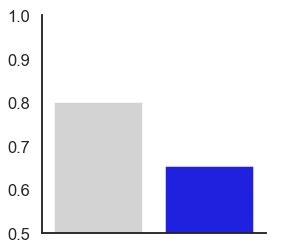

In [62]:
import seaborn as sns
sns.set(style="white", context="talk")

xdata = ['MaSIF-site', 'SPPIDER']
ydata = [np.median(all_auc_per_protein_per_res_masif), \
        np.median(all_res_roc_auc_per_prot_sppider) ]

f, (ax1) = plt.subplots(1, 1, figsize=(4, 4), sharex=False)

plt.ylim([0.5,1.0])

sns.barplot(x=xdata, y=ydata, ax=ax1, palette=['lightgray', 'blue'])

ax1.set_ylim([0.5,1])
ax1.set_xticks([])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#axes[0].spines['right'].set_visible(False)
#axes[0].spines['top'].set_visible(False)


print(ydata)

plt.savefig('sppider_bars.pdf', type='pdf')

0.758564778111


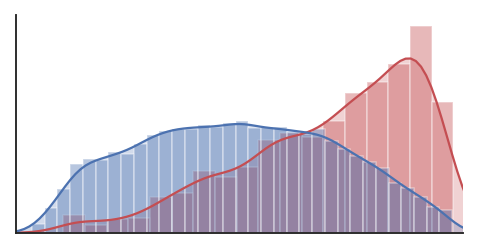

In [74]:
# Plot per residue for MsSIF
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
#sns.set(style="white", context="talk")


pos_label = np.where(all_my_labels_per_res_masif == 1)[0]
pos = all_my_pred_per_res_masif[pos_label]
neg_label = np.where(all_my_labels_per_res_masif == 0)[0]
neg = all_my_pred_per_res_masif[neg_label]


f, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=False)
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True},ax=ax,  norm_hist=False)
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True},ax=ax, norm_hist=False)
plt.xlim([0,1])
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print(metrics.roc_auc_score(all_my_labels_per_res_masif, all_my_pred_per_res_masif))
#plt.savefig('dist_plot_ours.pdf', type='pdf')


0.784267893242


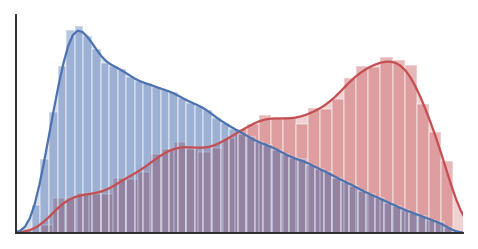

In [79]:
# Plot per point for MsSIF
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
#sns.set(style="white", context="talk")


pos_label = np.where(all_labels_masif == 1)[0]
pos = all_scores_masif[pos_label]
neg_label = np.where(all_labels_masif == 0)[0]
neg = all_scores_masif[neg_label]


f, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=False)
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True},ax=ax,  norm_hist=True)
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True},ax=ax, norm_hist=True)
plt.xlim([0,1])
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print(metrics.roc_auc_score(all_labels_masif, all_scores_masif))
plt.savefig('dist_plot_masif_all_points_transient.pdf', type='pdf')


0.61074898633


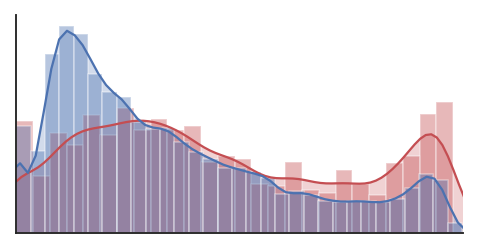

In [70]:
# SPPIDER dist plot -- all points.
pos_label = np.where(all_labels_by_point_sppider == 1)[0]
pos = all_pred_by_point_sppider[pos_label]
neg_label = np.where(all_labels_by_point_sppider == 0)[0]
neg = all_pred_by_point_sppider[neg_label]
f, ax = plt.subplots(1, 1, figsize=(8, 4), sharex=False)
sns.distplot(pos, hist=True, color='r', kde_kws={"shade": True},ax=ax,  norm_hist=True)
sns.distplot(neg, hist=True, color='b', kde_kws={"shade": True},ax=ax, norm_hist=True)
plt.xlim([0,1])
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#axes[1].spines['top'].set_visible(False)
#axes[0].spines['right'].set_visible(False)
#axes[0].spines['top'].set_visible(False)
print(metrics.roc_auc_score(all_labels_by_point_sppider, all_pred_by_point_sppider))
plt.savefig('dist_plot_sppider.pdf', type='pdf')
